In [1]:
import torch
import clip
import open_clip
import matplotlib.pyplot as plt
from PIL import Image

from exclip import OpenClipExplainer, OpenAIExplainer
from exclip.tokenization import OpenClipTokenizer, OpenAITokenizer
from exclip.utils import image_utils, plotting

/mount/arbeitsdaten/tcl/Users/moellels/anaconda/envs/exclip-pip/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Initialization
loading a model either form **OpenAI** or **OpenClip** and wrapping it into our Explainer classes.
Due to slight differences in the implementations, we provide the respective subclasses `OpenAIExplainer` and `OpenClipExplainer`. 
We also implement additional functionalities for tokenization in the `OpenAITokenizer` and the `OpenClipTokenizer`, making token selection easier (see below).

In [2]:
# OpenClip model

# device = 'cuda:0'
# model_name = 'ViT-B-16'
# pretraining = 'laion2b_s34b_b88k'
# model, _, prep = open_clip.create_model_and_transforms(model_name, pretraining)
# model.to(device)
# model.eval()  # model in train mode by default
# explainer = OpenClipExplainer(model, device=device)
# tokenizer = OpenClipTokenizer(model_name)  # OpenClip tokenizers can be model specific

In [3]:
# OpenAI model

device = 'cuda:0'
model_name = 'ViT-B/16'
model, prep = clip.load(model_name, device=device)
explainer = OpenAIExplainer(model, device=device)
tokenizer = OpenAITokenizer()

### Image and Caption
We use PIL to load an image and type in a caption. You can change the caption or load a different image.
The `image_utils.crop` method performs the same center crop and downsampling as the impage preparation below.
We will use the cropped image for visualization later.

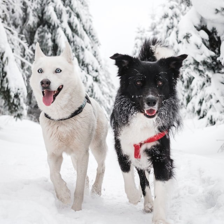

In [4]:
caption = 'A white husky and a black dog running in a snow covered forest.'
image = Image.open("examples/dogs.jpg")
cropped_image = image_utils.crop(image, resolution=224)
cropped_image

Preparing both caption and image input tensors.

In [5]:
txt_inpt = tokenizer.tokenize(caption).to(device)
img_inpt = prep(image).unsqueeze(0).to(device)

### Computing explanations
The Explainers' `explain` method computes our second-order attributions for interactions between the image and the caption.
We can choose a hidden representation to attribute to in both encoders (`text_layer` and `image_layer`) and set the number of interpolation steps used for the computation $N$ (cf. Equation in the paper). A higher $N$ will result in more accurate attribution but higher computational cost. 

The final attributions $A$ are a 3d tensor with an importance weight for every interaction between a token and and image patch.

In [6]:
A = explainer.explain(
    txt_inpt, img_inpt, 
    text_layer=11, 
    image_layer=11,  
    N=10,
    verbose=True,
)
A.shape

100%|██████████| 512/512 [00:01<00:00, 461.11it/s]


torch.Size([16, 14, 14])

### Visualization

We can visualize our 3d attributions by selecting a token range from the caption and projecting it onto the image by summation.
To make the token selection easier, our Tokenizer wrappers provide a `print_tokens` method, separating the caption into tokens and printing them together with their index. Counting starts at one due to the preceding `CLS` token.

In [7]:
tokenizer.print_tokens(caption)

'1-a 2-white 3-husky 4-and 5-a 6-black 7-dog 8-running 9-in 10-a 11-snow 12-covered 13-forest 14-.'

From the above caption, we select the range [5:8] corresponding to "a black dog" and visualize its correspondence to the image.
You can change the token range to anything else, e.g. [0:4] for "a white husky" or [10:14] for "a snow covered forest".

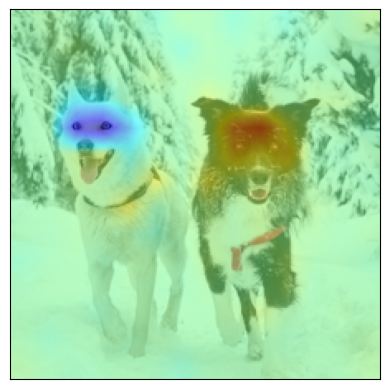

In [8]:
# selection and projection
img_attr = A[5:8].sum(dim=0)
# plotting heatmap
heat = plotting.image_attribution_interpolation(
    image=cropped_image,
    A=img_attr,
    alpha=.5
)
plt.imshow(heat)
plt.xticks([])
plt.yticks([])
plt.show()

Shades of red / blue correspond to positive / negative attribution resepctively.